In [26]:
import pickle 
import pandas as pd
import numpy as np
import training
import metrics
from xgboost import XGBRegressor

from training import predict
from matplotlib import pyplot as plt

In [7]:
import importlib
importlib.reload(training)

<module 'training' from 'C:\\Users\\asus\\Python\\PollutionAnalysis\\training.py'>

# Feature importances

Посмотрим как меняются feature importances на графиках в зависимости от горизонта

In [ ]:
models = pickle.load(open('models/xgboost_v3', 'rb'))

In [9]:
data = pd.read_csv('data/data_v4/data.csv').dropna()
Y = pd.read_csv('data/data_v4/y.csv')

In [4]:
features_scaled = pickle.load(open('data/data_v4.1/features_scaled', 'rb'))

In [7]:
importances_cm = np.array([m.estimators_[0].feature_importances_ for m in models])
importances_benz = np.array([m.estimators_[1].feature_importances_ for m in models])
importances_no = np.array([m.estimators_[2].feature_importances_ for m in models])

In [8]:
imp_table_сm = pd.DataFrame(importances_cm, columns=data.columns[1:])
imp_table_benz = pd.DataFrame(importances_benz, columns=data.columns[1:])
imp_table_no = pd.DataFrame(importances_no, columns=data.columns[1:])

In [9]:
cm_means, benz_means, no_means = imp_table_сm.mean(), imp_table_benz.mean(), imp_table_no.mean()

In [170]:
p = 0.01

In [171]:
features_cm, features_benz, features_no = cm_means[cm_means > p], benz_means[benz_means > p], no_means[no_means > p]

In [172]:
def feature_importance_plot(importances, features):
    plt.rcParams['figure.figsize'] = (40, 20)
    for i in range(len(importances[0])):
        plt.plot(range(len(importances[:, i])), importances[:, i], label=features[i])
    plt.legend()

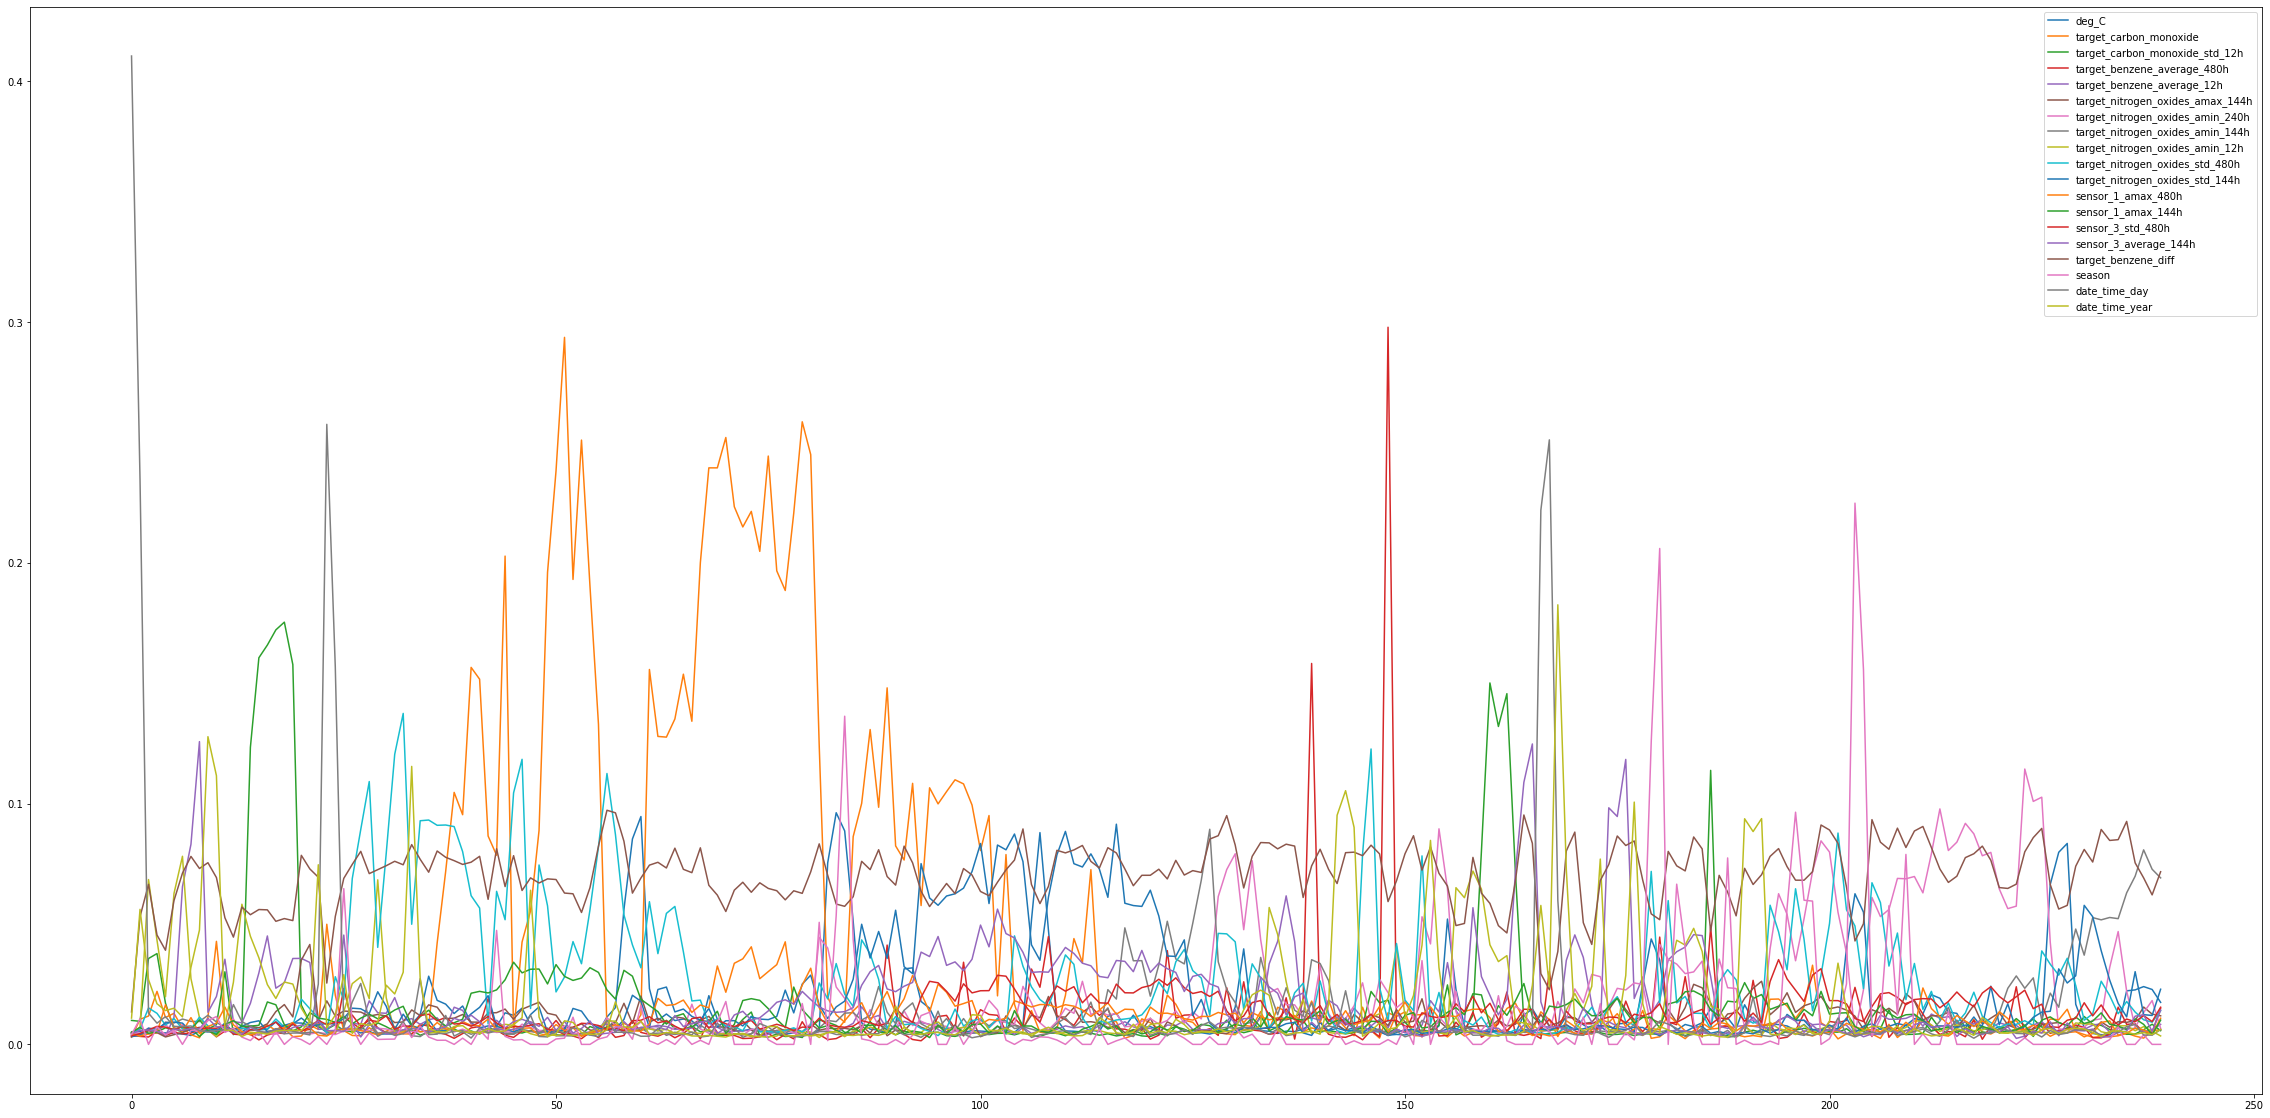

In [173]:
feature_importance_plot(np.array(imp_table_сm[features_cm.keys()]), features_cm.keys())

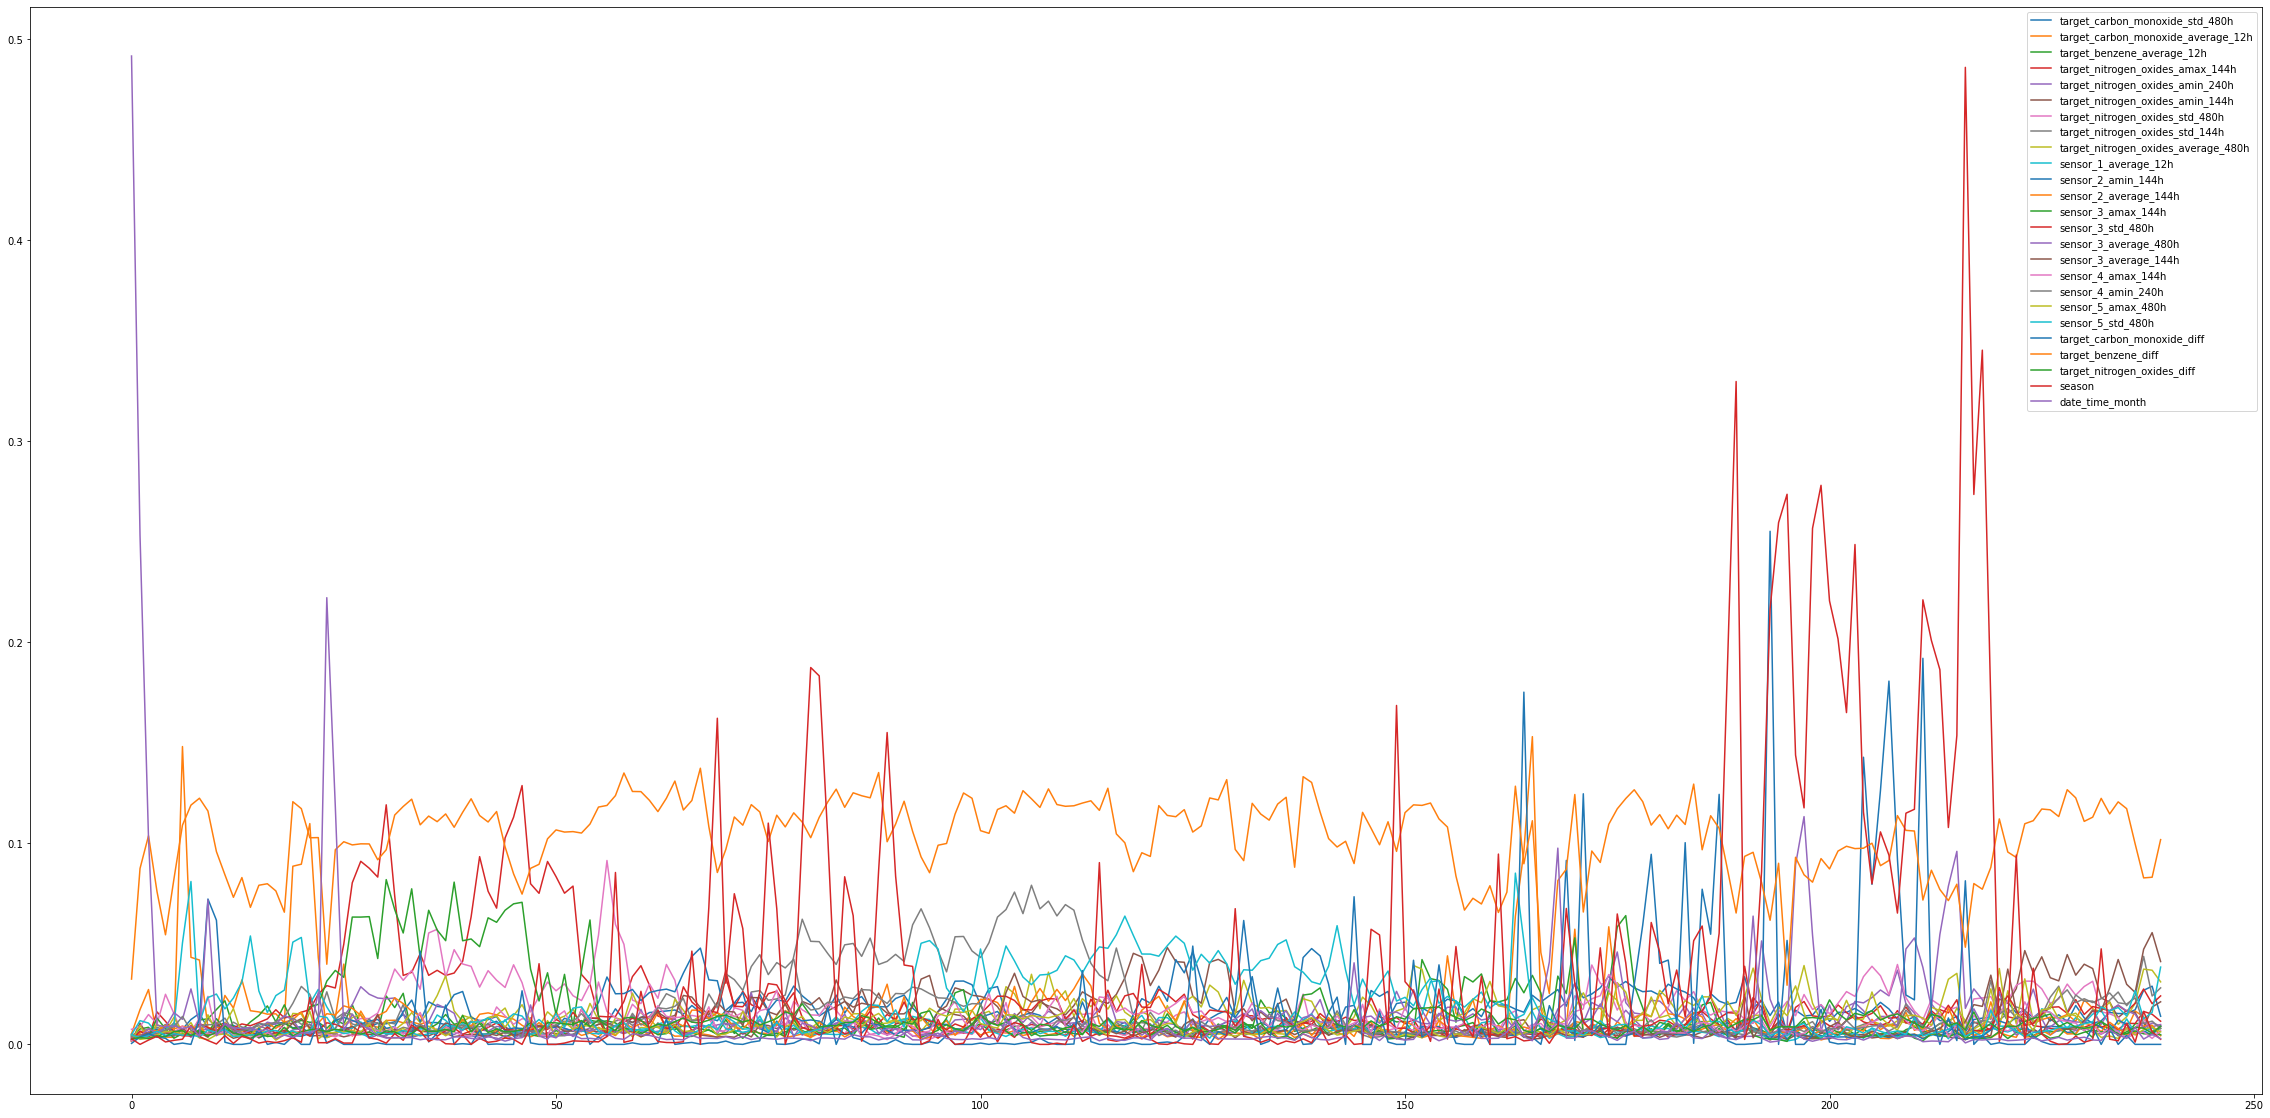

In [174]:
feature_importance_plot(np.array(imp_table_benz[features_benz.keys()]), features_benz.keys())

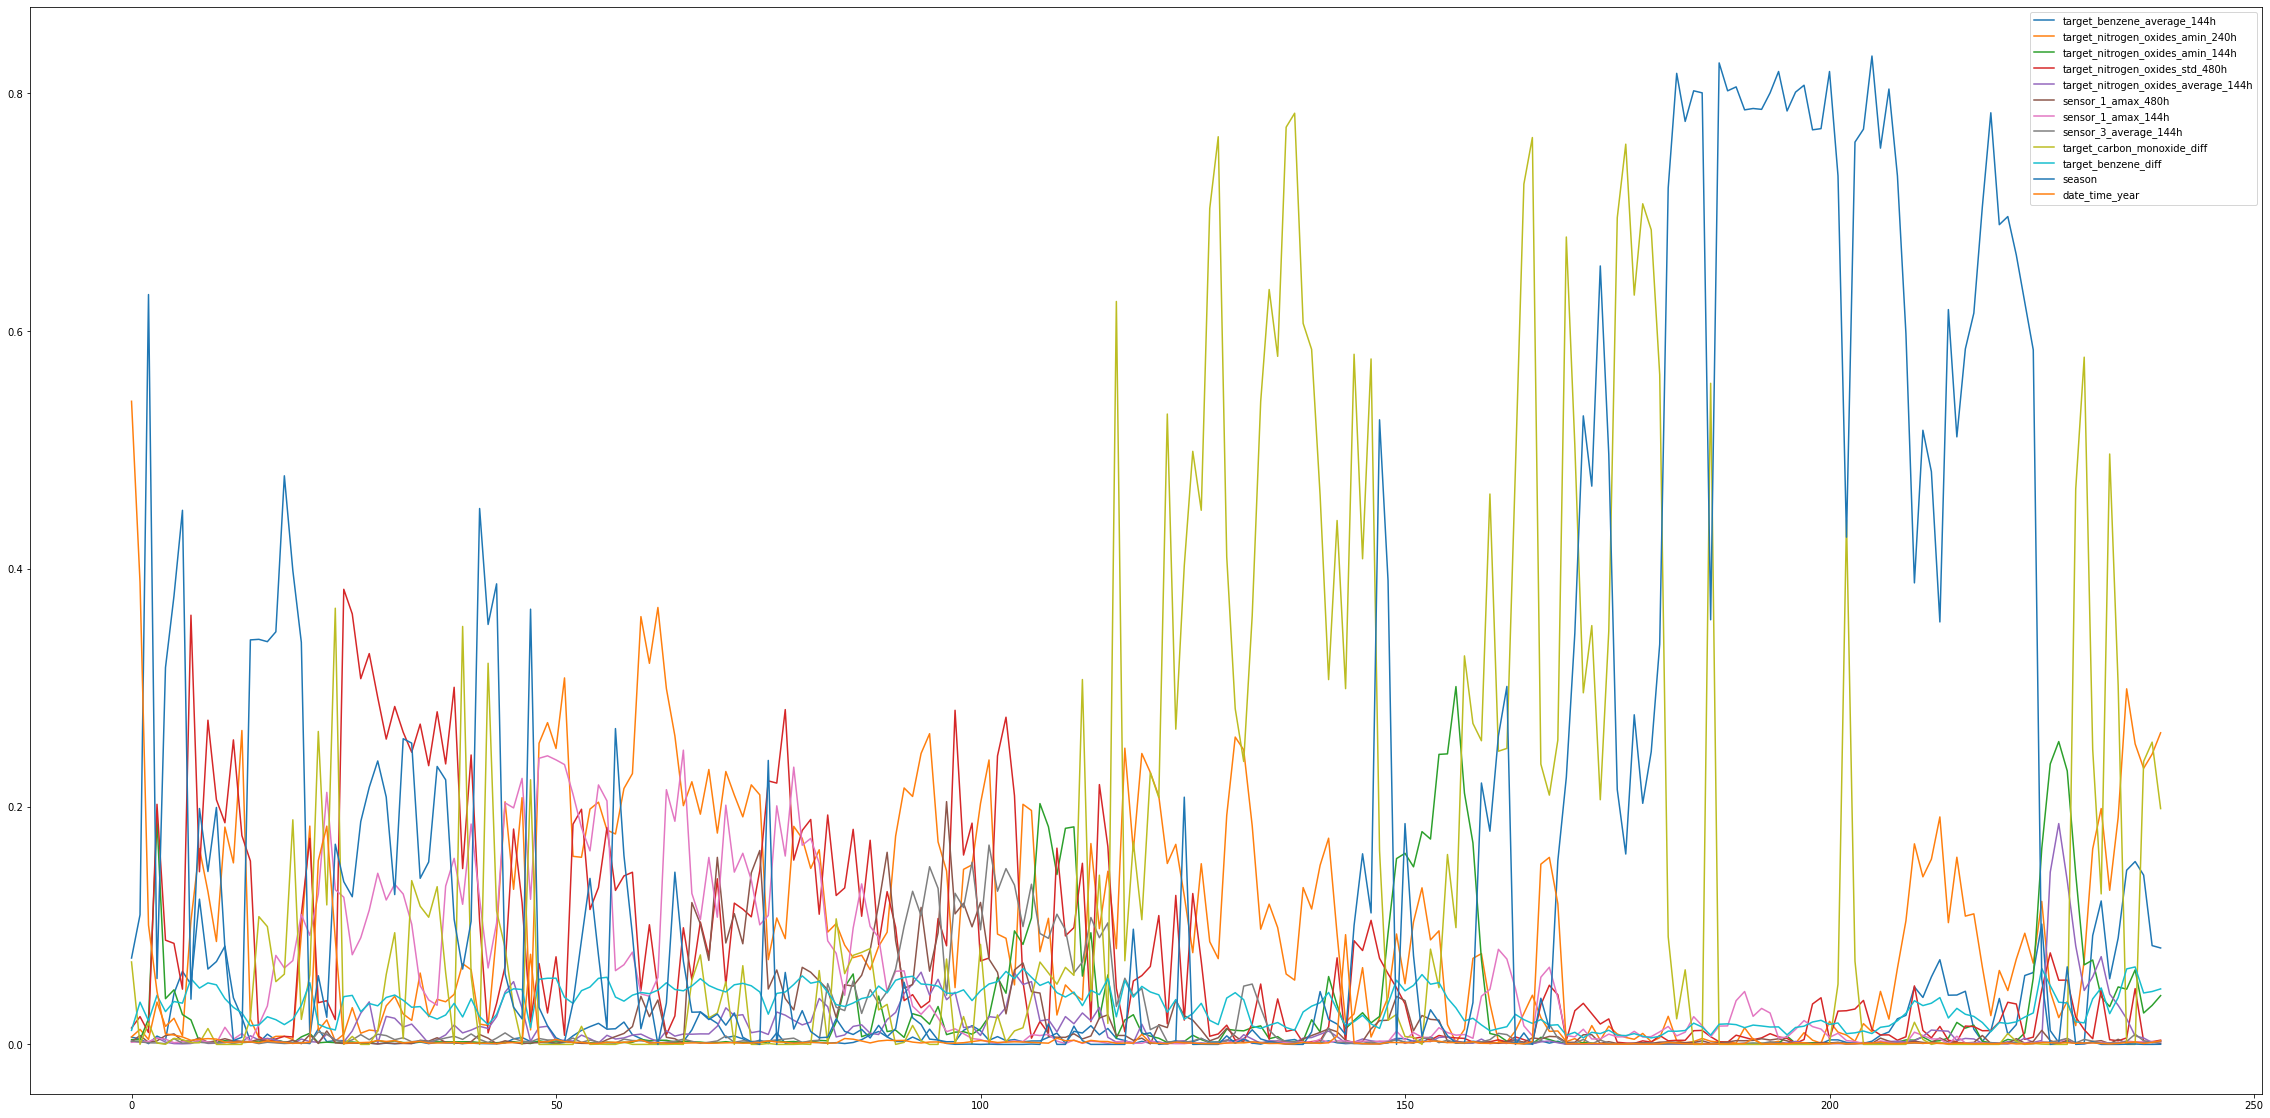

In [175]:
feature_importance_plot(np.array(imp_table_no[features_no.keys()]), features_no.keys())

Можно заметить, что самое большое значение обычно имеют оконные функции таргетов и сенсоров на достаточно большой промежуток времени, а также производные

## Evaluation

Сравним градиентный бустинг, случайный лес и некоторые линейные модели

In [2]:
xgboost = pickle.load(open('models/xgboost_v3', 'rb'))
lasso = pickle.load(open('models/lasso_v1', 'rb'))
ridge = pickle.load(open('models/ridge_v1', 'rb'))
forest = pickle.load(open('models/forest_v1', 'rb'))

In [3]:
h = 24*10

In [13]:
result_boost = predict(xgboost, data.iloc[-h, 1:])
result_lasso = predict(lasso, features_scaled[-h])
result_ridge = predict(ridge, features_scaled[-h])
result_forest = predict(forest, data.iloc[-h, 1:])

In [27]:
models = [xgboost, lasso, ridge, forest]
metrics_list = [metrics.MAE, metrics.RelativeAE]
results = [result_boost, result_lasso, result_ridge, result_forest]

In [18]:
Y_test = Y.iloc[-h:]

In [37]:
tables = [[[metric(result, Y_test)[i] for metric in metrics_list] for result in results] for i in range(3)]

df_tables = [pd.DataFrame(table, columns=['MAE', 'RelativeAE'], index=['xgboost', 'lasso', 'ridge', 'forest']) for table in tables]

In [42]:
errors = pd.concat(df_tables, keys=['carbon_monoxide', 'benzene', 'nitrogen_oxides'], axis=1)

In [43]:
errors

carbon_monoxide              benzene            nitrogen_oxides  \
                    MAE RelativeAE       MAE RelativeAE             MAE   
xgboost        1.593663   0.677554  6.303759   0.782509      183.109398   
lasso          1.603478   0.681727  6.592939   0.818406      246.810162   
ridge          1.726971   0.734230  7.407197   0.919482      241.309266   
forest         1.873136   0.796373  7.799239   0.968148      238.175207   

                    
        RelativeAE  
xgboost   0.577219  
lasso     0.778024  
ridge     0.760683  
forest    0.750804